# AI Lab — 动手搭建第一个AI项目

在本实验中，我们将从头搭建一个类似于你画我猜的项目，创建简单的工具来识别图纸并输出当前图纸的名称。

你可以先行在演示环境中尝试一番，提前感受下你将完成的项目情况，[点击进入](http://139.219.128.254:8008/)。

![](https://github.com/ddebby/labs/blob/master/pics/1.png?raw=1)

**项目的开发过程包括如下基本步骤：**
> 1. 数据的准备
> 2. 相关配置环境的准备
> 3. 数据预处理
> 4. 模型的选型及设计
> 5. 模型的部署及测试

**在本实验中将用到如下工具和技能：**
- TensorFlow >v1.5.0
- Keras
- TensorFlow.js
- numpy

![](https://github.com/ddebby/labs/blob/master/pics/3.png?raw=1)

## 1. 数据准备

数据集方面，我们使用Google开源的涂鸦数据集：[The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)

![](https://github.com/ddebby/labs/blob/master/pics/2.jpg?raw=1)
它共有5000万副涂鸦画，覆盖了345个分类。为了减少实验中的训练时间，我们在本实验中使用了其中的100个常用分类。

每张图像通过如下信息进行定义：

| Key         | Type                    | Description                                                  |
| ----------- | ----------------------- | ------------------------------------------------------------ |
| key_id      | 64-bit unsigned integer | A unique identifier across all   drawings.                   |
| word        | string                  | Category the player was prompted to   draw.                  |
| recognized  | boolean                 | Whether the word was recognized by the   game.               |
| timestamp   | datetime                | When the drawing was created.                                |
| countrycode | string                  | A two letter country code ([ISO 3166-1   alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)) of where the player was located. |
| drawing     | string                  | A JSON array representing the vector   drawing               |

比如：

```python
  { 
    "key_id":"5891796615823360",
    "word":"nose",
    "countrycode":"AE",
    "timestamp":"2017-03-01 20:41:36.70725 UTC",
    "recognized":true,
    "drawing":[[[129,128,129,129,130,130,131,132,132,133,133,133,133,...]]]
  }
```

在本实验中，我们使用 `.npy` 存储的数据格式，可以直接使用`numpy`以矩阵的形式加载数据，方便处理。

### 数据下载
> 如果使用本脚本，相关内容已经完成下载，不需要再单独下载内容！

### 查看类别情况
> 相关类名进行了汉化处理

In [1]:
!wget https://github.com/ddebby/labs/blob/master/class_names.txt
f = open("class_names.txt","r")
# And for reading use
classes = f.readlines()
f.close()

classes = [c.replace('\n','').replace(' ','_') for c in classes]

--2018-09-11 09:48:14--  https://github.com/ddebby/labs/blob/master/class_names.txt
Resolving github.com (github.com)... 52.74.223.119, 13.250.177.223, 13.229.188.59
Connecting to github.com (github.com)|52.74.223.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘class_names.txt.1’

class_names.txt.1       [  <=>               ]  57.96K   238KB/s    in 0.2s    

2018-09-11 09:48:15 (238 KB/s) - ‘class_names.txt.1’ saved [59346]



In [2]:
classes

['螺丝刀',
 '手表',
 '蝴蝶',
 '刀剑',
 '猫',
 '猎枪',
 '眼睛',
 '棒棒糖',
 '棒球',
 '红绿灯',
 '太阳',
 '钢盔',
 '桥',
 '闹钟',
 '鼓',
 '书',
 '扫帚',
 '风扇',
 '剪刀',
 '云',
 '帐篷',
 '钟表',
 '耳机(头戴)',
 '自行车',
 '停止标志',
 '桌子',
 '甜甜圈',
 '雨伞',
 '笑脸',
 '枕头',
 '床',
 '锯',
 '电灯泡',
 '铁锹',
 '鸟',
 '注射器',
 '咖啡杯',
 '月亮',
 '冰激凌',
 '胡须',
 '手机',
 '短裤',
 '铁砧',
 '收音机',
 '椅子',
 '星星',
 '门',
 '人脸',
 '蘑菇',
 '树',
 '来福枪',
 '相机',
 '闪电',
 '花',
 '篮球',
 '轮子',
 '锤子',
 '帽子',
 '小刀',
 '跳水板',
 '正方形',
 '茶杯',
 '山',
 '苹果',
 '汤匙',
 '钥匙',
 '铅笔',
 '直线',
 '梯子',
 '三角形',
 'T恤',
 '哑铃',
 '麦克风',
 '蛇',
 '短裤',
 '手提箱',
 '笔记本电脑',
 '回形针',
 '彩虹',
 '蜡烛',
 '面包',
 '蜘蛛',
 '信封',
 '圆圈',
 '电源插座',
 '牙齿',
 '热狗',
 '煎锅',
 '长凳',
 '吊扇',
 '网球拍',
 '汽车',
 '胡须',
 '斧子',
 '棒球球棒',
 '披萨',
 '葡萄',
 '眼睛',
 '饼干',
 '飞机']

### 查看文件
所有文件都是以`.npy`的格式存储在 `data`目录下

In [4]:
!ls /data2/ailab -l --b=m | more

total 10604M
-rw-r--r-- 1 gaoc root 114M Sep 11 06:34 airplane.npy
-rw-r--r-- 1 gaoc root  93M Sep 11 07:33 alarm clock.npy
-rw-r--r-- 1 gaoc root  95M Sep 11 06:32 anvil.npy
-rw-r--r-- 1 gaoc root 109M Sep 11 07:22 apple.npy
-rw-r--r-- 1 gaoc root  93M Sep 11 07:33 axe.npy
-rw-r--r-- 1 gaoc root  93M Sep 11 06:32 baseball bat.npy
-rw-r--r-- 1 gaoc root 102M Sep 11 07:35 baseball.npy
-rw-r--r-- 1 gaoc root 101M Sep 11 07:33 basketball.npy
-rw-r--r-- 1 gaoc root 124M Sep 11 07:34 beard.npy
-rw-r--r-- 1 gaoc root  86M Sep 11 07:22 bed.npy
-rw-r--r-- 1 gaoc root  97M Sep 11 07:34 bench.npy
-rw-r--r-- 1 gaoc root  95M Sep 11 07:35 bicycle.npy
-rw-r--r-- 1 gaoc root 100M Sep 11 07:34 bird.npy
-rw-r--r-- 1 gaoc root  90M Sep 11 06:32 book.npy
-rw-r--r-- 1 gaoc root  91M Sep 11 06:32 bread.npy
-rw-r--r-- 1 gaoc root 100M Sep 11 07:34 bridge.npy
-rw-r--r-- 1 gaoc root  88M Sep 11 07:33 broom.npy
-rw-r--r-- 1 gaoc root  89M Sep 11 07:34 butterfly.npy
-rw-r--r-- 1 gaoc root  97M Sep 11 07:33 cam

## 2. 导入基本模块

In [6]:
import os
import glob
import numpy as np
import keras
from keras import layers
#from tensorflow import keras 
import tensorflow as tf

Using TensorFlow backend.


In [7]:
print(tf.__version__)

1.4.0


In [8]:
print(keras.__version__)

2.0.6


## 3. 加载数据 

每个类别的数据在模型上可用作形状为 [N，784] 的 numpy 数组，其中 N 是该特定类的图像数。

In [9]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [10]:
x_train, y_train, x_test, y_test, class_names = load_data('/data2/ailab')
num_classes = len(class_names)
image_size = 28

In [11]:
print(len(x_train),len(x_test))

320000 80000


In [12]:
x_train.shape

(320000, 784)

### 随机查看一组数据

ceiling fan


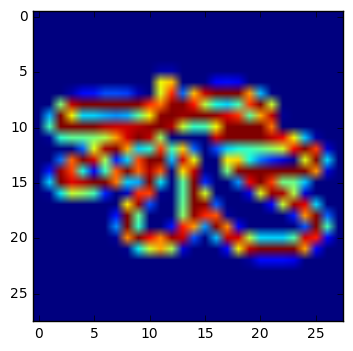

In [16]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

### 数据预处理
- 将图像数据存储格式转化为[28,28,1]的矩阵表示；
- 将标签数据转化为One-hot表示，每个类别使用一个100维的向量描述。

In [17]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [18]:
print(x_train.shape,y_train.shape)

(320000, 28, 28, 1) (320000, 100)


## 4. 建模
我们将创建一个简单的 CNN。 请注意，参数数量越少，模型越简单越好。 实际上，我们将在浏览器转换后运行模型，并且我们希望让模型快速运行并进行预测。 以下模型包含 3 个转换层和 2 个密集层。

In [20]:
# Define model
model = keras.models.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

## 5.训练
我们基于 5 个 epochs 和 256 个 batch 训练模型， 40-50s一个epoch，总的训练时间大概在5分钟左右

In [21]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=5)

Train on 288000 samples, validate on 32000 samples
Epoch 1/5
72s - loss: 1.9716 - top_k_categorical_accuracy: 0.7742 - val_loss: 1.3888 - val_top_k_categorical_accuracy: 0.8763
Epoch 2/5
71s - loss: 1.2627 - top_k_categorical_accuracy: 0.8903 - val_loss: 1.1649 - val_top_k_categorical_accuracy: 0.9013
Epoch 3/5
73s - loss: 1.0980 - top_k_categorical_accuracy: 0.9088 - val_loss: 1.0806 - val_top_k_categorical_accuracy: 0.9114
Epoch 4/5
74s - loss: 1.0081 - top_k_categorical_accuracy: 0.9180 - val_loss: 0.9896 - val_top_k_categorical_accuracy: 0.9193
Epoch 5/5
74s - loss: 0.9477 - top_k_categorical_accuracy: 0.9238 - val_loss: 0.9683 - val_top_k_categorical_accuracy: 0.9213


## 6. 测试

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 91.96%


## 7. 推理 

['tooth', 'book', 'pants', 'table', 'diving board']


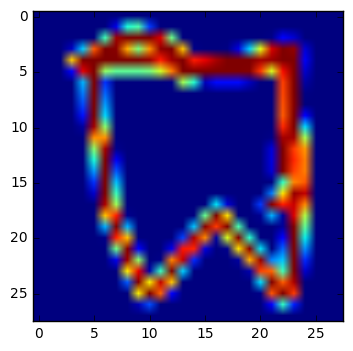

In [23]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

## 8. 模型导出

### 存储标签名称

In [24]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

###  安装TensorFlowJS

In [26]:
# 在该环境下已经安装完毕，不需要重新安装
#!sudo pip install tensorflowjs 

The directory '/home/gaoc/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/gaoc/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
    100% |████████████████████████████████| 2.7MB 49.4MB/s ta 0:00:01
    100% |████████████████████████████████| 348kB 59.6MB/s ta 0:00:01
    100% |████████████████████████████████| 12.1MB 83.7MB/s ta 0:00:011
    100% |████████████████████████████████| 51.2MB 67.9MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 58.1MB/s ta 0:00:01
    100% |████████████████████████████████| 3.3MB 87.5MB/s ta 0:00:01
anago 1.0.7 has requirement nu

### 下载基本的Web框架

In [28]:
!git clone https://github.com/ddebby/labs.git

Cloning into 'labs'...
remote: Counting objects: 39, done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 39 (delta 8), reused 34 (delta 3), pack-reused 0
Unpacking objects: 100% (39/39), done.
Checking connectivity... done.


### 存储和转换模型 

In [27]:
model.save('keras.h5')

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:119: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [29]:
!tensorflowjs_converter --input_format keras keras.h5 labs/model/

Using TensorFlow backend.


In [31]:
!ls -l labs/model

total 440
-rw-r--r-- 1 gaoc root 440208 Sep 11 10:05 group1-shard1of1
-rw-r--r-- 1 gaoc root   4250 Sep 11 10:05 model.json


### 压缩及获取

In [32]:
!cp class_names.txt labs/model/class_names.txt

In [33]:
!zip -r lab.zip labs 

  adding: labs/ (stored 0%)
  adding: labs/fabric.js (deflated 80%)
  adding: labs/mini_classes.txt (deflated 41%)
  adding: labs/pics/ (stored 0%)
  adding: labs/pics/1.png (deflated 2%)
  adding: labs/pics/5.png (deflated 10%)
  adding: labs/pics/2.jpg (deflated 20%)
  adding: labs/pics/config.png (deflated 8%)
  adding: labs/pics/3.png (deflated 4%)
  adding: labs/pics/webserver4chrome.png (deflated 10%)
  adding: labs/main.css (deflated 63%)
  adding: labs/README.md (deflated 27%)
  adding: labs/pie.js (deflated 62%)
  adding: labs/model/ (stored 0%)
  adding: labs/model/class_names.txt (deflated 41%)
  adding: labs/model/model.json (deflated 84%)
  adding: labs/model/group1-shard1of1 (deflated 7%)
  adding: labs/class_names.txt (deflated 29%)
  adding: labs/.git/ (stored 0%)
  adding: labs/.git/logs/ (stored 0%)
  adding: labs/.git/logs/HEAD (deflated 29%)
  adding: labs/.git/logs/refs/ (stored 0%)
  adding: labs/.git/logs/refs/remotes/ (stored 0%)
  adding: labs/.git/logs/refs/re

点击左上角`File`---`Open...`,找到`lab.zip`，下载到本地

## 9.部署
在本机环境部署需要搭建一个Web Server，可以使用Windows的IIS或者使用Chrome的Web Server插件，本试验简单对其使用做一个基本介绍，相关配置可以根据每个人的环境不同进行调整。

### 使用Chrome的网络服务器（可选）
1. 在Chrome浏览器中进入插件安装页面：[Web Server for Chrome](https://chrome.google.com/webstore/detail/web-server-for-chrome/ofhbbkphhbklhfoeikjpcbhemlocgigb/related?hl=en)
![](https://github.com/ddebby/labs/blob/master/pics/webserver4chrome.png?raw=1)

2. 配置Web Server for Chrome， 将文件目录定位到本地`index.html`所在目录，同时可以根据需求重新配置端口（默认为8887）

![](https://github.com/ddebby/labs/blob/master/pics/config.png?raw=1)

3. 可以通过访问本机的 http://127.0.0.1:8887 来访问完成的AI项目

![](https://github.com/ddebby/labs/blob/master/pics/index.png?raw=1)